In [0]:
# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Imports

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D, Activation, Lambda, Add, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
import keras.backend as K

from utils import plot_accuracy_and_loss, plot_confusion_matrix, plot_smoothed_acc_and_loss, extract_features
from oct_conv2d import OctConv2D

Using TensorFlow backend.


# Parameters

In [2]:
train_dir = 'dogs_32/train/'
#validation_dir = 'dogs/validation/'
test_dir = 'dogs_32/test/'

STD_SIZE = (32, 32)
BATCH_SIZE = 128
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

In [3]:
def lr_scheduler(epoch):
    x = 1e-3
    if epoch >= 50: x /= 10.0
    if epoch >= 100: x /= 10.0
    if epoch >= 150: x /= 10.0
    return x

# Data preparation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 16418 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Mexican_hairless', 'Newfoundl

# Baseline

## Model

In [7]:
inputs = Input(shape=(32, 32, 3))
y = Conv2D(48, (3, 3), activation='relu', padding='same')(inputs)
y = Conv2D(48, (3, 3), activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Conv2D(96, (3, 3), activation='relu', padding='same')(y)
y = Conv2D(96, (3, 3), activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Conv2D(192, (3, 3), activation='relu', padding='same')(y)
y = Conv2D(192, (3, 3), activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Dropout(0.25)(y)

y = Flatten()(y)
y = Dense(512, activation='relu')(y)
y = Dropout(0.5)(y)
y = Dense(256, activation='relu')(y)
y = Dropout(0.5)(y)
outputs = Dense(120, activation='softmax')(y)
model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-3),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=100, verbose=2,
    validation_data=test_generator, validation_steps=test_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + '9_layers_dogs_alpha_0', monitor='val_acc', save_best_only=True, verbose=1),
               LearningRateScheduler(lr_scheduler)
              ])

with open(PATH + '9_layers_dogs_alpha_0_history', 'wb') as f:
    pickle.dump(history.history, f)

W0717 23:42:09.608554  2756 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0717 23:42:09.614554  2756 deprecation.py:506] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0717 23:42:09.703559  2756 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0717 23:42:09.709560  2756 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages

Epoch 1/100
 - 136s - loss: 4.7871 - acc: 0.0101 - val_loss: 4.7826 - val_acc: 0.0115

Epoch 00001: val_acc improved from -inf to 0.01147, saving model to 9_layers_dogs_alpha_0
Epoch 2/100
 - 13s - loss: 4.7846 - acc: 0.0095 - val_loss: 4.7803 - val_acc: 0.0119

Epoch 00002: val_acc improved from 0.01147 to 0.01190, saving model to 9_layers_dogs_alpha_0
Epoch 3/100
 - 12s - loss: 4.7824 - acc: 0.0113 - val_loss: 4.7795 - val_acc: 0.0121

Epoch 00003: val_acc improved from 0.01190 to 0.01215, saving model to 9_layers_dogs_alpha_0
Epoch 4/100
 - 13s - loss: 4.7828 - acc: 0.0121 - val_loss: 4.7766 - val_acc: 0.0134

Epoch 00004: val_acc improved from 0.01215 to 0.01339, saving model to 9_layers_dogs_alpha_0
Epoch 5/100
 - 13s - loss: 4.7659 - acc: 0.0140 - val_loss: 4.7001 - val_acc: 0.0198

Epoch 00005: val_acc improved from 0.01339 to 0.01983, saving model to 9_layers_dogs_alpha_0
Epoch 6/100
 - 13s - loss: 4.7013 - acc: 0.0186 - val_loss: 4.6172 - val_acc: 0.0258

Epoch 00006: val_acc 


Epoch 00052: val_acc improved from 0.12072 to 0.12940, saving model to 9_layers_dogs_alpha_0
Epoch 53/100
 - 12s - loss: 3.6999 - acc: 0.1289 - val_loss: 3.6773 - val_acc: 0.1277

Epoch 00053: val_acc did not improve from 0.12940
Epoch 54/100
 - 12s - loss: 3.6905 - acc: 0.1303 - val_loss: 3.6624 - val_acc: 0.1222

Epoch 00054: val_acc did not improve from 0.12940
Epoch 55/100
 - 12s - loss: 3.6766 - acc: 0.1348 - val_loss: 3.6726 - val_acc: 0.1279

Epoch 00055: val_acc did not improve from 0.12940
Epoch 56/100
 - 12s - loss: 3.6783 - acc: 0.1320 - val_loss: 3.6735 - val_acc: 0.1289

Epoch 00056: val_acc did not improve from 0.12940
Epoch 57/100
 - 12s - loss: 3.6746 - acc: 0.1352 - val_loss: 3.6730 - val_acc: 0.1225

Epoch 00057: val_acc did not improve from 0.12940
Epoch 58/100
 - 12s - loss: 3.6520 - acc: 0.1364 - val_loss: 3.6632 - val_acc: 0.1336

Epoch 00058: val_acc improved from 0.12940 to 0.13361, saving model to 9_layers_dogs_alpha_0
Epoch 59/100
 - 12s - loss: 3.6602 - acc:

## Results

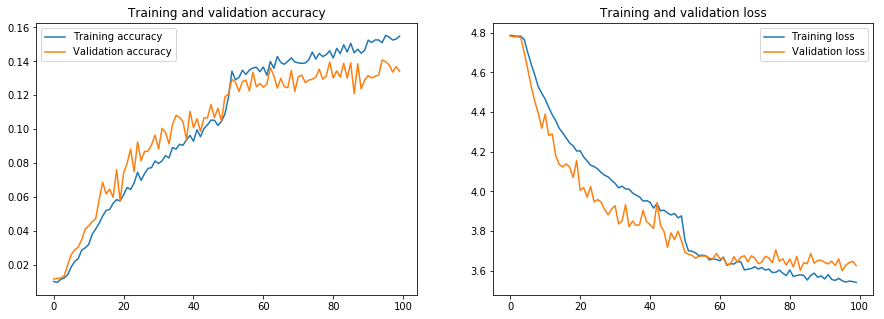

In [8]:
plot_accuracy_and_loss(history.history)

In [9]:
model = load_model(PATH + '9_layers_dogs_alpha_0')
model.evaluate(test_features, test_labels)

4162/4162 [==============================] - 1s 331us/step


[3.6384806510406524, 0.13791446419990389]

For alpha = 0:
 Max test accuracy = 0.1408



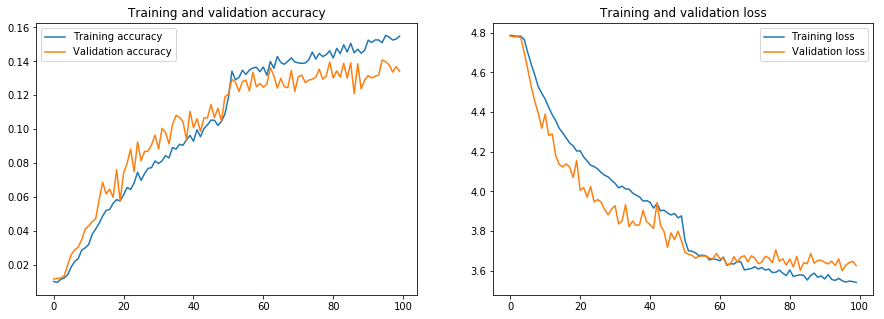

In [10]:
with open(PATH + '9_layers_dogs_alpha_0_history', 'rb') as f:
    history = pickle.load(f)
    print(f"For alpha = 0:\n Max test accuracy = {max(history['val_acc']):.04}\n")

plot_accuracy_and_loss(history)

# OctConv

In [5]:
for alpha in [0.125, 0.25, 0.5, 0.75]:
    inputs = Input(shape=(32, 32, 3))
    low = AveragePooling2D(2)(inputs)
    
    high, low = OctConv2D(filters=32, alpha=alpha)([inputs, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    
    high, low = MaxPooling2D(2)(high), MaxPooling2D(2)(low)
    
    high, low = OctConv2D(filters=64, alpha=alpha)([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    high, low = OctConv2D(filters=64, alpha=alpha)([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    
    high, low = MaxPooling2D(2)(high), MaxPooling2D(2)(low)
    
    high, low = OctConv2D(filters=128, alpha=alpha)([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)

    high = Conv2D(128, 3, padding='same')(high)
    low = Conv2D(128, 3, padding='same')(low)
    low = Lambda(lambda x: K.repeat_elements(K.repeat_elements(x, 2, axis=1), 2, axis=2))(low)
    x = Add()([high, low])
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    flat = Flatten()(x)
    outputs = Dense(512, activation='relu')(flat)
    outputs = Dense(120, activation='softmax')(outputs)
    
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(lr=1e-3),
                  metrics=['accuracy'])
    history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=100, verbose=2,
    validation_data=test_generator, validation_steps=test_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + f'9_layers_dogs_alpha_{alpha}', monitor='val_acc', save_best_only=True, verbose=1),
               LearningRateScheduler(lr_scheduler)
              ])

    with open(PATH + f'9_layers_dogs_alpha_{alpha}_history', 'wb') as f:
        pickle.dump(history.history, f)

W0718 01:23:25.481068  5172 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 01:23:25.498069  5172 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 01:23:25.501069  5172 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0718 01:23:25.508069  5172 deprecation.py:506] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a futur

Epoch 1/100
 - 16s - loss: 4.7455 - acc: 0.0157 - val_loss: 4.5777 - val_acc: 0.0242

Epoch 00001: val_acc improved from -inf to 0.02417, saving model to 9_layers_dogs_alpha_0.125
Epoch 2/100
 - 12s - loss: 4.5905 - acc: 0.0260 - val_loss: 4.4506 - val_acc: 0.0340

Epoch 00002: val_acc improved from 0.02417 to 0.03396, saving model to 9_layers_dogs_alpha_0.125
Epoch 3/100
 - 12s - loss: 4.4898 - acc: 0.0324 - val_loss: 4.3790 - val_acc: 0.0456

Epoch 00003: val_acc improved from 0.03396 to 0.04561, saving model to 9_layers_dogs_alpha_0.125
Epoch 4/100
 - 12s - loss: 4.4158 - acc: 0.0432 - val_loss: 4.2948 - val_acc: 0.0565

Epoch 00004: val_acc improved from 0.04561 to 0.05652, saving model to 9_layers_dogs_alpha_0.125
Epoch 5/100
 - 12s - loss: 4.3695 - acc: 0.0501 - val_loss: 4.2474 - val_acc: 0.0573

Epoch 00005: val_acc improved from 0.05652 to 0.05726, saving model to 9_layers_dogs_alpha_0.125
Epoch 6/100
 - 12s - loss: 4.3130 - acc: 0.0510 - val_loss: 4.2281 - val_acc: 0.0625

Ep

 - 12s - loss: 2.5858 - acc: 0.3535 - val_loss: 4.2650 - val_acc: 0.1539

Epoch 00052: val_acc improved from 0.14898 to 0.15394, saving model to 9_layers_dogs_alpha_0.125
Epoch 53/100
 - 12s - loss: 2.5611 - acc: 0.3554 - val_loss: 4.2857 - val_acc: 0.1559

Epoch 00053: val_acc improved from 0.15394 to 0.15592, saving model to 9_layers_dogs_alpha_0.125
Epoch 54/100
 - 12s - loss: 2.5360 - acc: 0.3624 - val_loss: 4.3676 - val_acc: 0.1477

Epoch 00054: val_acc did not improve from 0.15592
Epoch 55/100
 - 12s - loss: 2.5021 - acc: 0.3707 - val_loss: 4.3807 - val_acc: 0.1572

Epoch 00055: val_acc improved from 0.15592 to 0.15716, saving model to 9_layers_dogs_alpha_0.125
Epoch 56/100
 - 12s - loss: 2.5020 - acc: 0.3713 - val_loss: 4.3371 - val_acc: 0.1507

Epoch 00056: val_acc did not improve from 0.15716
Epoch 57/100
 - 12s - loss: 2.5238 - acc: 0.3651 - val_loss: 4.3862 - val_acc: 0.1423

Epoch 00057: val_acc did not improve from 0.15716
Epoch 58/100
 - 12s - loss: 2.4770 - acc: 0.3751 -


Epoch 00008: val_acc did not improve from 0.06619
Epoch 9/100
 - 12s - loss: 4.1626 - acc: 0.0745 - val_loss: 4.2276 - val_acc: 0.0600

Epoch 00009: val_acc did not improve from 0.06619
Epoch 10/100
 - 12s - loss: 4.1247 - acc: 0.0791 - val_loss: 4.0972 - val_acc: 0.0801

Epoch 00010: val_acc improved from 0.06619 to 0.08007, saving model to 9_layers_dogs_alpha_0.25
Epoch 11/100
 - 12s - loss: 4.0797 - acc: 0.0868 - val_loss: 4.0852 - val_acc: 0.0813

Epoch 00011: val_acc improved from 0.08007 to 0.08131, saving model to 9_layers_dogs_alpha_0.25
Epoch 12/100
 - 12s - loss: 4.0334 - acc: 0.0928 - val_loss: 4.0388 - val_acc: 0.0927

Epoch 00012: val_acc improved from 0.08131 to 0.09271, saving model to 9_layers_dogs_alpha_0.25
Epoch 13/100
 - 12s - loss: 4.0046 - acc: 0.0959 - val_loss: 4.0098 - val_acc: 0.1004

Epoch 00013: val_acc improved from 0.09271 to 0.10040, saving model to 9_layers_dogs_alpha_0.25
Epoch 14/100
 - 12s - loss: 3.9716 - acc: 0.1005 - val_loss: 3.9706 - val_acc: 0.

 - 12s - loss: 2.4330 - acc: 0.3855 - val_loss: 4.4984 - val_acc: 0.1465

Epoch 00063: val_acc did not improve from 0.15444
Epoch 64/100
 - 12s - loss: 2.4223 - acc: 0.3876 - val_loss: 4.5930 - val_acc: 0.1497

Epoch 00064: val_acc did not improve from 0.15444
Epoch 65/100
 - 12s - loss: 2.4171 - acc: 0.3880 - val_loss: 4.5794 - val_acc: 0.1487

Epoch 00065: val_acc did not improve from 0.15444
Epoch 66/100
 - 12s - loss: 2.3946 - acc: 0.3933 - val_loss: 4.5987 - val_acc: 0.1472

Epoch 00066: val_acc did not improve from 0.15444
Epoch 67/100
 - 12s - loss: 2.4007 - acc: 0.3973 - val_loss: 4.5384 - val_acc: 0.1501

Epoch 00067: val_acc did not improve from 0.15444
Epoch 68/100
 - 12s - loss: 2.3746 - acc: 0.3909 - val_loss: 4.6540 - val_acc: 0.1433

Epoch 00068: val_acc did not improve from 0.15444
Epoch 69/100
 - 12s - loss: 2.3837 - acc: 0.3967 - val_loss: 4.6368 - val_acc: 0.1458

Epoch 00069: val_acc did not improve from 0.15444
Epoch 70/100
 - 12s - loss: 2.3868 - acc: 0.3945 - val


Epoch 00019: val_acc did not improve from 0.10585
Epoch 20/100
 - 12s - loss: 3.8067 - acc: 0.1237 - val_loss: 3.9200 - val_acc: 0.1093

Epoch 00020: val_acc improved from 0.10585 to 0.10932, saving model to 9_layers_dogs_alpha_0.5
Epoch 21/100
 - 12s - loss: 3.7820 - acc: 0.1284 - val_loss: 3.9955 - val_acc: 0.1036

Epoch 00021: val_acc did not improve from 0.10932
Epoch 22/100
 - 12s - loss: 3.7585 - acc: 0.1321 - val_loss: 4.0294 - val_acc: 0.1054

Epoch 00022: val_acc did not improve from 0.10932
Epoch 23/100
 - 12s - loss: 3.7205 - acc: 0.1379 - val_loss: 4.0428 - val_acc: 0.0979

Epoch 00023: val_acc did not improve from 0.10932
Epoch 24/100
 - 12s - loss: 3.7030 - acc: 0.1387 - val_loss: 3.9773 - val_acc: 0.1101

Epoch 00024: val_acc improved from 0.10932 to 0.11006, saving model to 9_layers_dogs_alpha_0.5
Epoch 25/100
 - 12s - loss: 3.6781 - acc: 0.1432 - val_loss: 4.0226 - val_acc: 0.1135

Epoch 00025: val_acc improved from 0.11006 to 0.11353, saving model to 9_layers_dogs_al


Epoch 00077: val_acc did not improve from 0.13783
Epoch 78/100
 - 12s - loss: 2.4546 - acc: 0.3797 - val_loss: 4.9494 - val_acc: 0.1217

Epoch 00078: val_acc did not improve from 0.13783
Epoch 79/100
 - 12s - loss: 2.4578 - acc: 0.3749 - val_loss: 4.9207 - val_acc: 0.1210

Epoch 00079: val_acc did not improve from 0.13783
Epoch 80/100
 - 12s - loss: 2.4246 - acc: 0.3842 - val_loss: 4.9976 - val_acc: 0.1287

Epoch 00080: val_acc did not improve from 0.13783
Epoch 81/100
 - 12s - loss: 2.4244 - acc: 0.3874 - val_loss: 4.9343 - val_acc: 0.1282

Epoch 00081: val_acc did not improve from 0.13783
Epoch 82/100
 - 12s - loss: 2.4114 - acc: 0.3899 - val_loss: 5.0083 - val_acc: 0.1282

Epoch 00082: val_acc did not improve from 0.13783
Epoch 83/100
 - 12s - loss: 2.4381 - acc: 0.3868 - val_loss: 4.9453 - val_acc: 0.1217

Epoch 00083: val_acc did not improve from 0.13783
Epoch 84/100
 - 12s - loss: 2.4328 - acc: 0.3851 - val_loss: 5.0559 - val_acc: 0.1292

Epoch 00084: val_acc did not improve fro

 - 12s - loss: 3.5592 - acc: 0.1643 - val_loss: 4.1478 - val_acc: 0.1098

Epoch 00033: val_acc did not improve from 0.11874
Epoch 34/100
 - 12s - loss: 3.5315 - acc: 0.1681 - val_loss: 4.2341 - val_acc: 0.1006

Epoch 00034: val_acc did not improve from 0.11874
Epoch 35/100
 - 12s - loss: 3.5014 - acc: 0.1718 - val_loss: 4.3831 - val_acc: 0.0930

Epoch 00035: val_acc did not improve from 0.11874
Epoch 36/100
 - 12s - loss: 3.4832 - acc: 0.1792 - val_loss: 4.0726 - val_acc: 0.1063

Epoch 00036: val_acc did not improve from 0.11874
Epoch 37/100
 - 12s - loss: 3.4641 - acc: 0.1775 - val_loss: 4.3357 - val_acc: 0.1009

Epoch 00037: val_acc did not improve from 0.11874
Epoch 38/100
 - 12s - loss: 3.4173 - acc: 0.1811 - val_loss: 4.0698 - val_acc: 0.1215

Epoch 00038: val_acc improved from 0.11874 to 0.12147, saving model to 9_layers_dogs_alpha_0.75
Epoch 39/100
 - 12s - loss: 3.4331 - acc: 0.1861 - val_loss: 4.1867 - val_acc: 0.1168

Epoch 00039: val_acc did not improve from 0.12147
Epoch 40


Epoch 00091: val_acc did not improve from 0.13064
Epoch 92/100
 - 12s - loss: 2.5806 - acc: 0.3512 - val_loss: 4.8377 - val_acc: 0.1133

Epoch 00092: val_acc did not improve from 0.13064
Epoch 93/100
 - 12s - loss: 2.5567 - acc: 0.3576 - val_loss: 4.8585 - val_acc: 0.1247

Epoch 00093: val_acc did not improve from 0.13064
Epoch 94/100
 - 12s - loss: 2.5535 - acc: 0.3569 - val_loss: 4.8912 - val_acc: 0.1235

Epoch 00094: val_acc did not improve from 0.13064
Epoch 95/100
 - 12s - loss: 2.5384 - acc: 0.3632 - val_loss: 5.0141 - val_acc: 0.1252

Epoch 00095: val_acc did not improve from 0.13064
Epoch 96/100
 - 12s - loss: 2.5106 - acc: 0.3739 - val_loss: 4.9437 - val_acc: 0.1257

Epoch 00096: val_acc did not improve from 0.13064
Epoch 97/100
 - 12s - loss: 2.5419 - acc: 0.3653 - val_loss: 4.9645 - val_acc: 0.1215

Epoch 00097: val_acc did not improve from 0.13064
Epoch 98/100
 - 12s - loss: 2.5214 - acc: 0.3666 - val_loss: 4.9751 - val_acc: 0.1195

Epoch 00098: val_acc did not improve fro

For alpha = 0:
 Max test accuracy = 0.1408



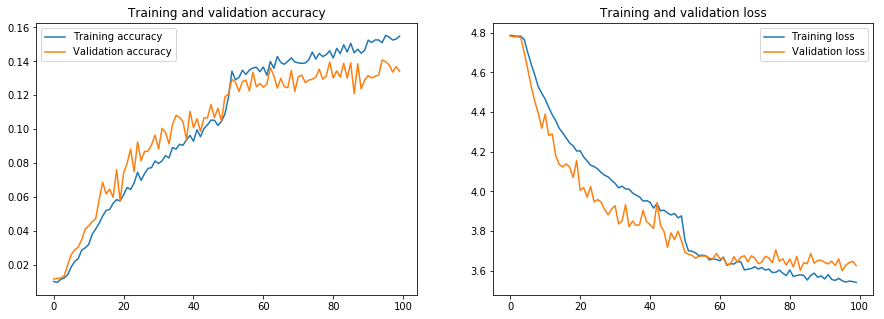

For alpha = 0.125:
 Max test accuracy = 0.1574



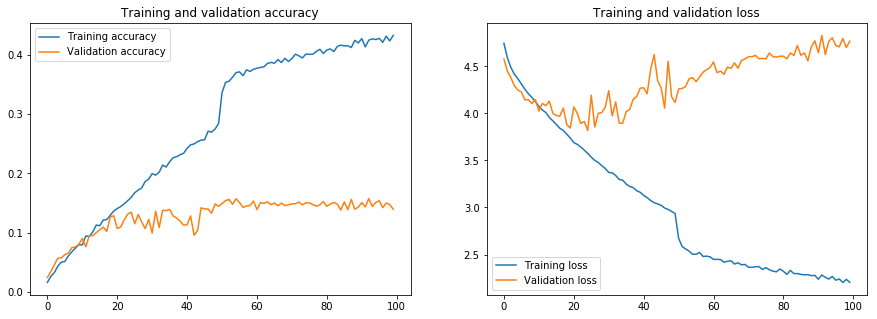

For alpha = 0.25:
 Max test accuracy = 0.1544



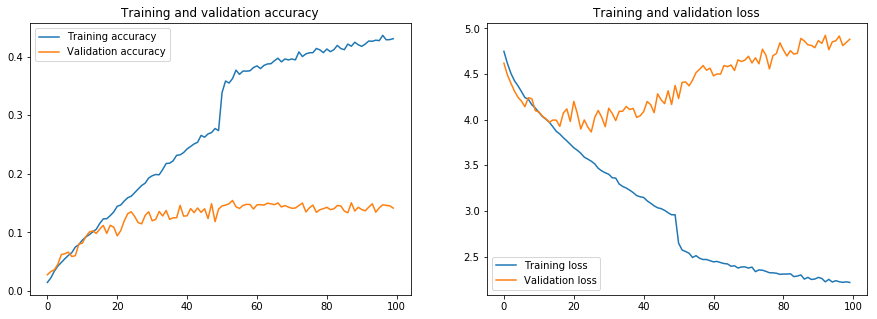

For alpha = 0.5:
 Max test accuracy = 0.1378



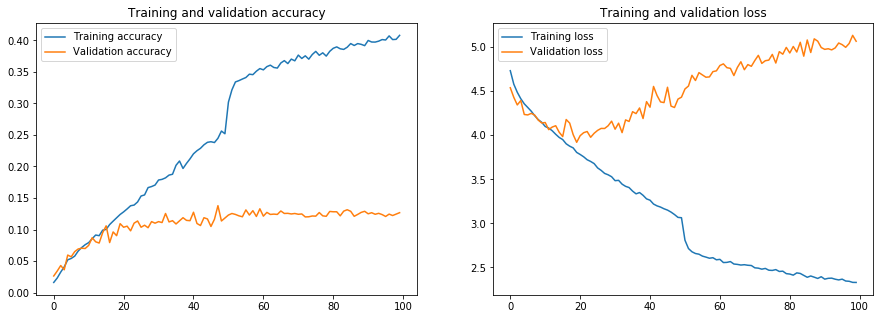

For alpha = 0.75:
 Max test accuracy = 0.1306



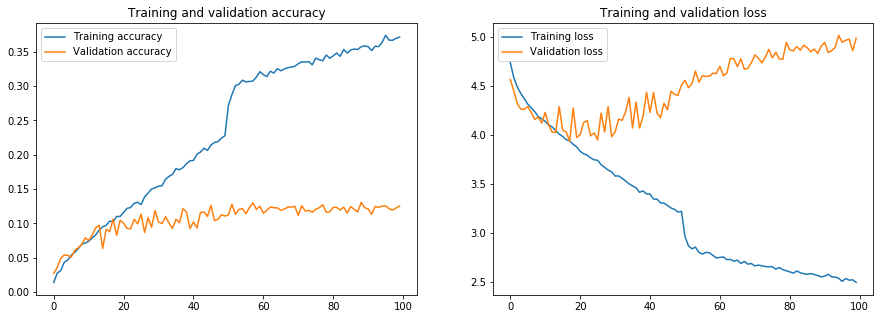

In [6]:
for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'9_layers_dogs_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        print(f"For alpha = {alpha}:\n Max test accuracy = {max(history['val_acc']):.04}\n")

    plot_accuracy_and_loss(history)

In [3]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

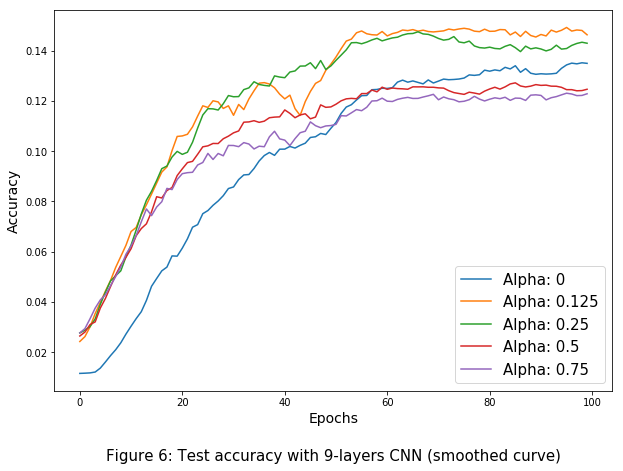

In [4]:
fig, ax = plt.subplots(figsize=(10, 7))

for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'9_layers_dogs_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        ax.plot(smooth_curve(history['val_acc'][:100]), label=f"Alpha: {alpha}", )

ax.set_xlabel('Epochs', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title("Figure 6: Test accuracy with 9-layers CNN (smoothed curve)", size=15, y=-.2)
ax.legend(prop={'size': 15})

plt.show()